Privacy Experiments on Adult Census Data accompanying thesis: 


Implements the following:
* Neural Network Victim Model, with custom PyTorch data loader for Tabular Data.
* Shadow Model Attack With Variants:
  - Different Model Release Mechanisms
  - Sub-Group Aware Attacks
  - Original Shadow Model Attack and a variant of shadow modeling without multiple models for each outcome.
* Implements Worst Case estimators of Vulnerability to Membership Inference Attacks.  
* Implements Framework for Simulation based analysis of Model Centric Estimates of disparity to membership inference attacks. 



Analysis Requires Pandas Library version 1.5.0 or greater.

In [ ]:
!pip install pandas==1.5.0

Basic Python Libraries.

In [ ]:
import pandas as pd
import numpy as np 
import os 
from copy import copy

SKLearn Models Needed.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

Classification Metrics.

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import zero_one_loss
from sklearn.metrics import log_loss

Preprocessing Functions.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

Plotting / Visualization Libraries.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

PyTorch Functions

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

Libraries for Estimating Total Variation Distance.

In [ ]:
from scipy.stats import ks_2samp
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde as kde
from scipy.integrate import quad

Libraries for Repeated Measures ANOVA.

In [ ]:
from statsmodels.stats.anova import AnovaRM
from scipy import stats
from statsmodels.stats.multicomp import MultiComparison

Disable Warnings

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Group Variables Needed in Tests of Disparity (Named after Race column is one hot encoded).

In [ ]:
grp_cols = [ 'race_Asian-Pac-Islander',
             'race_Black',
             'race_Other',
             'race_White']

Helper Function Used in Analysis to Reverse-One Hotted Partition of the Population of interest- in this notebook it is currently race.

In [ ]:
def reverse_one_hot( X , grp_cols):
    # will have to add sep and default later on 
    # utility function for calculation group accuracy metrics 
    tmp = pd.from_dummies(X[grp_cols], sep = "race_", default_category = "Amer-Indian-Eskimo")
    tmp = tmp.to_numpy()
    X['race'] = tmp 

Function For Pre-processing the data in format for Victim Classification Model and conducting Shadow Modeling Attacks - Splits Data in Train, Test, and Reference (for constructing shadow data sets).

In [ ]:
def create_data(seed_num):
  path1 = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
  data = pd.read_csv(path1 , header = None , skipinitialspace = True )

  path2 = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test" 
  data2 = pd.read_csv(path2 , skiprows = [0] , header = None  , skipinitialspace = True)


  data = pd.concat( (data , data2) , axis = 0 )

  del data2
  data.columns = ["age",
                  "workclass",
                   "fnlwgt",
                  "education",
                  "education_num",
                  "marital_status",
                  "occupation",
                  "relationship",
                  "race",
                  "sex",
                  "capital_gain",
                  "capital_loss",
                  "hours_per_week",
                  "native_country",
                  "outcome"]



  # merge like categories 
  data.age = data.age.astype(float)
  data['hours_per_week'] =  data['hours_per_week'].astype(float)

  data = data.dropna()
  # drop these useless columns 
  data.drop(['fnlwgt', 'education_num'], axis = 1 , inplace = True)

  data['education'].replace('Preschool', 'dropout',inplace=True)
  data['education'].replace('10th', 'dropout',inplace=True)
  data['education'].replace('11th', 'dropout',inplace=True)
  data['education'].replace('12th', 'dropout',inplace=True)
  data['education'].replace('1st-4th', 'dropout',inplace=True)
  data['education'].replace('5th-6th', 'dropout',inplace=True)
  data['education'].replace('7th-8th', 'dropout',inplace=True)
  data['education'].replace('9th', 'dropout',inplace=True)
  data['education'].replace('HS-Grad', 'HighGrad',inplace=True)
  data['education'].replace('HS-grad', 'HighGrad',inplace=True)
  data['education'].replace('Some-college', 'CommunityCollege',inplace=True)
  data['education'].replace('Assoc-acdm', 'CommunityCollege',inplace=True)
  data['education'].replace('Assoc-voc', 'CommunityCollege',inplace=True)
  data['education'].replace('Bachelors', 'Bachelors',inplace=True)
  data['education'].replace('Masters', 'Masters',inplace=True)
  data['education'].replace('Prof-school', 'Masters',inplace=True)
  data['education'].replace('Doctorate', 'Doctorate',inplace=True)


  data['marital_status'].replace('Never-married', 'NotMarried',inplace=True)
  data['marital_status'].replace(['Married-AF-spouse'], 'Married',inplace=True)
  data['marital_status'].replace(['Married-civ-spouse'], 'Married',inplace=True)
  data['marital_status'].replace(['Married-spouse-absent'], 'NotMarried',inplace=True)
  data['marital_status'].replace(['Separated'], 'Separated',inplace=True)
  data['marital_status'].replace(['Divorced'], 'Separated',inplace=True)
  data['marital_status'].replace(['Widowed'], 'Widowed',inplace=True)

  # select columns for one hot encoding 
  cols = data.drop("outcome", axis = 1 ).select_dtypes(include = ['object']).columns
  cols = list(cols)

  def create_features(X, cols = cols):
      Y = copy(X)
      Y.reset_index(inplace=True, drop=True)
      Y['outcome'] = np.where( Y['outcome'] == '>50K', 1, 0 )
      enc = OneHotEncoder(drop = "first")
      enc.fit(Y[cols])
      data_encoded = pd.DataFrame( enc.transform(Y[cols]).toarray() )
      data_encoded = data_encoded.astype('int32')
      data_encoded.columns = enc.get_feature_names_out(input_features = cols)
      Y = pd.concat([Y.drop(cols, axis = 1), data_encoded], axis = 1)
      return(Y)

  # create features and train / test set split 
  data = create_features(data)

  # split the data set 
  X_train, X_test = train_test_split(data , 
                                     train_size = round(0.4*data.shape[0]) , 
                                     random_state=seed_num)
  #X_train, X_test = train_test_split(data , train_size = 10000, random_state=42)
  # X_train, X_test = train_test_split(data , train_size = 24000, random_state=42)
  # do another split for reference data 

  X_test, X_ref = train_test_split(X_test,
                                   train_size = round(0.4*data.shape[0])  ,
                                   random_state = seed_num)
  
  num_cols = ['age', 'capital_gain', 'capital_loss', 'hours_per_week']
  # categorical columns
  cats = [col for col in X_train.columns
                      if col not in num_cols + ['outcome']]
  
  Normer = MinMaxScaler()
  # Normer.fit(X_train[num_cols])
  Normer.fit( data[num_cols])

  X_train[num_cols] = Normer.transform(X_train[num_cols])
  X_test[num_cols] = Normer.transform(X_test[num_cols])
  X_ref[num_cols] = Normer.transform(X_ref[num_cols])

  return X_train , X_test , X_ref , num_cols , cats 

Test the implementation.

In [ ]:
X_train , X_test , X_ref , num_cols , cats   = create_data(42)

PyTorch Implementation of Data Set Class for Tabular Data, Needed for Neural Network Victim Model.

In [ ]:
class TabularDataset(Dataset):
  def __init__(self, data, num_cols = None,  cat_cols=None, output_col=None):
    """
    Characterizes a Dataset for PyTorch

    Parameters
    ----------

    data: pandas data frame
      The data frame object for the input data. It must
      contain all the continuous, categorical and the
      output columns to be used.

    cat_cols: List of strings
      The names of the categorical columns in the data.
      These columns will be passed through the embedding
      layers in the model. These columns must be
      label encoded beforehand. 

    output_col: string
      The name of the output variable column in the data
      provided.
    """

    self.n = data.shape[0]

    
    self.y = data[output_col].astype(np.float32).values.reshape(-1,)

    self.cat_cols = cat_cols if cat_cols else []
    self.cont_cols = num_cols if num_cols else []

    #if self.cont_cols :
    #  self.cont_X = data[self.cont_cols].astype(np.float32).values
    #else:
      # self.cont_X = np.zeros((self.n, 1))

    #if self.cat_cols:
    #  self.cat_X = data[cat_cols].astype(np.int64).values
    #else:
    #   self.cat_X =  np.zeros((self.n, 1))


    if self.cont_cols is not None and   cat_cols is not None:
       self.cont_X = data[self.cont_cols].astype(np.float32).values
       self.cat_X = data[cat_cols].astype(np.int64).values
       self.X = np.concatenate( (self.cont_X ,self.cat_X ) , axis = 1  )
    elif self.cont_cols is not None and   cat_cols is None : 
       self.cont_X = data[self.cont_cols].astype(np.float32).values
       self.X = self.cont_X
    elif self.cont_cols is None and   cat_cols is not None : 
       self.cat_X = data[cat_cols].astype(np.int64).values
       self.X = self.cat_X  



    # self.X = np.concatenate( (self.cont_X ,self.cat_X ) , axis = 1  )

  def __len__(self):
    """
    Denotes the total number of samples.
    """
    return self.n

  def __getitem__(self, idx):
    """
    Generates one sample of data.
    """
    return [self.X[idx],self.y[idx]  ]

PyTorch Neural Network Victim - 1 hidden layer with log sigmoid output layer.

In [ ]:
class Net(nn.Module):

    def __init__(self, D_in, H, D_out):
        super().__init__()
        self.fc1 = nn.Linear(D_in, H)
        # self.fc2 = nn.Linear(H, H )
        self.fc3 = nn.Linear(H, D_out )
        
        self.relu = nn.ReLU()

    def forward(self, x):
        # layer 1 
        x = self.fc1(x)
        x = self.relu(x)

        # output layer 
        x = self.fc3(x)
        x = F.logsigmoid(x) # which output to use ... 

        return x.squeeze()



PyTorch Class that includes entire specification of the fitting procedure / parameters. Includes prediction method.

In [ ]:
class nn_victim(nn.Module) :
  # try to update to include fitting procedure
  def __init__(self ,mod = None):
    super().__init__()
    # instantiate the model if its not none 
    if mod is not None: 
      self.net = mod

  def fit(self, X,  epochs = 200, lr=0.01, batch_size  = 200 , weight_decay = 1e-07 ,
          num_cols = num_cols , cat_cols = cats,  output_col = 'outcome', D_in = 85 , plot = True ):
    n_epochs = epochs
    
    train= TabularDataset(X , num_cols = num_cols , cat_cols =cat_cols ,  output_col = output_col)
    trainloader = DataLoader(train, batch_size=batch_size , shuffle=True)

    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Define the model
    # D_in ,  H =  87 , 256
    D_in ,  H =  D_in , 32
    net = Net(D_in, H , 1 ).to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    # optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay = weight_decay)
    # remove weight decay
    optimizer = optim.SGD(net.parameters(), lr=lr )

    # Train the net
    loss_per_epoch = []
    test_loss_per_epoch = []
    for epoch in range(n_epochs):

        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):

            
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = net(inputs.float())
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            # Save loss to plot
            running_loss += loss.item()


            
        # add code to calculate testing loss per epoch here ... 
        loss_per_epoch.append(running_loss / (i + 1))
        #if epoch % 5 == 0 :
        #  print("Loss ", epoch , ":", running_loss / (i + 1)) 

    # save model to self for predictionm 
    self.net = net  
    # print("Training:", loss_per_epoch[-1]) 


    # Plot training loss curve
    # if plot :
     # plt.plot(np.arange(n_epochs), loss_per_epoch, "-",  label="Loss per epoch")
     # plt.xlabel("Number of epochs")
     # plt.ylabel("Loss")
     # plt.legend()
     # plt.show()   


  def predict_proba(self,newX):
    preds = self.net.forward( torch.from_numpy(newX).float()  )
    # last layer is log sigmoid , so exp the results to 
    preds =  np.exp( preds .detach().numpy() )
    return(preds) 

Test the class fits...

In [ ]:
victim = nn_victim()
victim.fit(X_train , epochs = 200 )

Class for estimating the Total Variation Distance between two distributions based on empirical samples. Not used in this notebook, but the privacy experiments can be configured to run this.

In [ ]:
class tvd_gap():
  def __init__(self, x_in , x_out):
    super().__init__()
    self.x_in = x_in
    self.x_out = x_out

    self.kern_in = kde(self.x_in)
    self.kern_out = kde(self.x_out)

  def kernel_diff(self , x_new):
      out = np.abs( self.kern_in.evaluate(x_new) -  
                    self.kern_out.evaluate(x_new) )
      return out

  def total_var_dist(self):
    # 1/2 the estimate ... 
    est , err = quad(self.kernel_diff, 0, 1 )
    return   0.5 * est  

 # also just use KS-two sample test as estimator 


class tvd_gap_2():
  def __init__(self, x_in , x_out):
    super().__init__()
    self.x_in = x_in.reshape(-1,1)
    self.x_out = x_out.reshape(-1,1)

    self.kern_in = KernelDensity(kernel= 'gaussian', bandwidth= "scott")
    self.kern_in.fit(self.x_in)

    self.kern_out = KernelDensity(kernel= 'gaussian', bandwidth= "scott")
    self.kern_out.fit(self.x_out)

  def kernel_diff(self , x_new):
      x_new = np.array(x_new).reshape(-1,1)
    
      out = np.abs( np.exp( self.kern_in.score(x_new)) -  
                      np.exp( self.kern_out.score(x_new)) )

      # out = min(  np.exp( self.kern_in.score(x_new))  ,
      #               np.exp( self.kern_out.score(x_new)) )
      return out

  def total_var_dist(self):
    # 1/2 the estimate ... 
    est1 , err1 = quad(self.kernel_diff, 0, 1 )


    return 0.5 * est1  # , 0.5 * est2  , 0.5* est3 

Class object for shadow model attack. Possible Configurations Include:
* Group Aware Attack - Includes Group Indicator Variables In Attack Feature Set.
* Multiple Attacks - Original Shadow Model Attack (one classifier for each outcome class) or only one attack model on entire attack data set.
* Zero One Output - Release Mechanism of Victim Model is Zero One Loss. Set to false to release the predicted probabilities.
* Sklearn model specifies whether the victim model is sklearn class or not.

In [ ]:
# from law notebook....
class attacker(nn.Module):
  def __init__(self,
               victim_model,
               N,
               size ,
               victim_model_class,
               attack_class, 
               ref_set ,
               group_aware ,
               group_cols,
               num_cols ,
               cat_cols , 
               multiple_attacks,
               zero_one_output,
               sklearn_model ):
    super().__init__()
    # initialize basic variables 
    self.victim_model = victim_model # model we are gonna hack 
    self.N = N                   # number 
    self.size = size             # number
    self.victim_model_class = victim_model_class # nn class
    self.attack_class = attack_class # attack class 
    self.ref_set = ref_set        # pd.dataframe

    # is / is not group aware attack 
    self.group_aware = group_aware  # boolean 
    self.group_cols = group_cols    # list
    self.num_cols = num_cols        # list
    self.cat_cols = cat_cols        # list 
    self.multiple_attacks = multiple_attacks # boolean multiple attacks or single model 

    self.zero_one_output = zero_one_output

    self.sklearn_model = sklearn_model 



  def reverse_one_hot(self, X , grp_cols):
    # will have to add sep and default later on 
    # utility function for calculation group accuracy metrics 
    tmp = pd.from_dummies(X[grp_cols], sep = "race_", default_category = "Amer-Indian-Eskimo")
    tmp.columns = ["race"]
    return pd.concat( (X, tmp), axis = 1 )      



  def shadow_model(self): 
    X_attack = None 

    # add only these columns to attack set
    if self.group_aware:
        cols = ['y_pred' , 'outcome',   'in'] + self.group_cols 
    else:
        cols = ['y_pred' , 'outcome',   'in']

    for i in range(self.N):
      # sample data with x 
    
      X = self.ref_set.sample(self.size*2)
      X_train_s, X_test_s = train_test_split(X, test_size = 0.5)

      # create classes for prediction purposes 
      train_s= TabularDataset(X_train_s ,
                              num_cols = self.num_cols ,
                              cat_cols = self.cat_cols ,
                              output_col = 'outcome')
      
      test_s = TabularDataset(X_test_s ,
                              num_cols = self.num_cols ,
                              cat_cols = self.cat_cols ,
                              output_col = 'outcome')
    
      # train shadow model here 
      # get train / test predictions
      # then label 0 / 1 and output a data set 

      shadow = self.victim_model_class()

      if self.sklearn_model is not True:
        shadow.fit(X_train_s , plot = False)
        y_pred_train = shadow.predict_proba( train_s.X )
        y_pred_test  = shadow.predict_proba( test_s.X )
      else:
        shadow.fit(X_train_s.drop('outcome', axis =1 ) , X_train_s['outcome']) 
        y_pred_train = shadow.predict_proba( X_train_s.drop('outcome', axis =1 )  )[:,1]
        y_pred_test  = shadow.predict_proba( X_test_s.drop('outcome', axis =1 ) )[:,1]
       


      if self.zero_one_output is True : 
        # make it a hard guess
        y_pred_train = np.where(y_pred_train >= 0.5 , 1, 0 )
        y_pred_test  = np.where(y_pred_test >= 0.5 , 1, 0 )

        # turn it into whether its correct or incorrect ... 
        y_pred_train = train_s.y ==  y_pred_train
        y_pred_test =  test_s.y == y_pred_test



      # add these and y_in / y_out to data sets

      y_in  = np.ones( (X_train_s.shape[0],1)) 
      y_out = np.zeros( (X_test_s.shape[0],1)) 
     
      # code from sklearn classifier ... 
      #X_train['y_pred'] = y_pred_train[:,1]
      #X_test['y_pred']  = y_pred_test[:,1]
      X_train_s['y_pred'] = y_pred_train
      X_test_s['y_pred']  = y_pred_test

      X_train_s['in']  = y_in
      X_test_s['in']   = y_out

    
      if X_attack is None:
         X_attack = pd.concat( (X_train_s[cols],
                             X_test_s[cols] ) , axis = 0 )
      else:
         X_attack = pd.concat( (X_attack,
                             X_train_s[cols] ,
                             X_test_s[cols]) , axis = 0 )
        

    # save the output for further access
    self.X_attack = X_attack 

  def estimate_vuln(self, Y_mem_label, Y_mem_pred): 
    # implement vuln estimation
    n1 = len(Y_mem_label)
    n2 = len(Y_mem_pred)
    member_idx = np.where(Y_mem_label ==1 , True , False )
    p1 = np.equal( Y_mem_label[member_idx] , Y_mem_pred[member_idx]  ).sum()
    p2 = np.equal( Y_mem_label[~member_idx] , Y_mem_pred[~member_idx]  ).sum()

    vuln = 2*( p1/n1 + p2/n2) -1 
    return(vuln)

    

  def solo_attack_train(self):
    # rewrite some codes here ....
    # for no loop over classes ....
    # idea is to also throw in outcome label itself 
    if self.group_aware:
           # cols = ['y_pred','in'] +grp_cols 
           pred_cols = ['y_pred' , 'outcome']  + grp_cols
           attack = self.attack_class(verbose = 0 , n_estimators =100 )
           attack.fit(self.data_train[pred_cols], self.data_train['in'])
           pred_y = attack.predict_proba(self.data_test[pred_cols])[:,1]
           y = self.data_test['in']
           models = attack 
    else:
          # cols = ['y_pred','in']
          pred_cols = ['y_pred' , 'outcome']   
          attack = self.attack_class(verbose = 0 , n_estimators = 100)
          attack.fit(self.data_train[pred_cols], self.data_train['in'])
          pred_y = attack.predict_proba(self.data_test[pred_cols])[:,1]
          y = self.data_test['in']
          models = attack 

    return(pred_y , y , models )      

  def multiple_attack_train(self):  
    out_classes = self.X_attack['outcome'].unique()
    out_classes = list(out_classes)
    true_y = []
    pred_y = []
    # for future use ... to save models or make it a class 
    models = {}
    for c in out_classes:
        # better yet train test split the attack data ...
        # print('Training attack model for class {}...'.format(c))
        # grab the rows for just one of the outcomes 
        c_train_indices = np.where( self.data_train['outcome'] == c ,True, False )
        c_test_indices = np.where( self.data_test['outcome'] == c ,True, False )

        c_train_data = self.data_train.loc[c_train_indices]
        c_test_data = self.data_test.loc[c_test_indices]


        # get attack model per class 

        if self.group_aware:
           cols = ['y_pred','in'] +grp_cols 
           pred_cols = ['y_pred']  + grp_cols
           attack = self.attack_class(verbose = 0 , n_estimators = 100)
           attack.fit(c_train_data[pred_cols], c_train_data['in'])
           c_pred_y = attack.predict_proba(c_test_data[pred_cols])[:,1]
           c_y = c_test_data['in']
        else:
          cols = ['y_pred','in']
          pred_cols = ['y_pred']  
          attack = self.attack_class(verbose = 0, n_estimators = 100 )
          attack.fit(c_train_data[pred_cols], c_train_data['in'])
          c_pred_y = attack.predict_proba(c_test_data[pred_cols])[:,1]
          c_y = c_test_data['in']
      
        models[c] = attack
        true_y.append(c_y)
        pred_y.append(c_pred_y)

    true_y = np.concatenate(true_y)
    pred_y = np.concatenate(pred_y)
    return pred_y , true_y , models 
   


  def train(self):  
    out_classes = self.X_attack['outcome'].unique()
    out_classes = list(out_classes)
    # build a model for each class 
    data_train , data_test = train_test_split(self.X_attack , test_size = 0.25 )
    self.data_train = data_train
    self.data_test = data_test 

    if self.multiple_attacks:
       pred_y, true_y , models = self.multiple_attack_train()
    else:  
      pred_y, true_y , models = self.solo_attack_train()
    
    
    # plt.hist(pred_y)
    # plt.show()
    hard_pred_y = np.where(pred_y >= 0.5, 1,0)
    # print("Shadow Data Attack AUC: " , roc_auc_score(true_y, pred_y))  
    # print("Shadow Data Attack Accuracy: " , roc_auc_score(true_y, hard_pred_y))
    # print("Shadow Data Attack Precision " , precision_score(true_y, hard_pred_y))  
    
    # save the models 
    self.attack_models = models  

  def multiple_attack_predict(self , X , y):
    # repeat procedure ... 
     preds = []
     labels = []
     for c in list(self.attack_models.keys()) :

        c_indices = np.where( X['outcome'] == c ,True, False )
        c_data = X.loc[c_indices]
        if self.group_aware:
          pred_cols = ['y_pred'] + self.group_cols
          # y_pred = self.attack_models[c].predict_proba(c_data[pred_cols].to_numpy())
          y_pred = self.attack_models[c].predict_proba(c_data[pred_cols])[:,1]
          X.loc[c_indices, ['mia_pred']] = y_pred
          # y = y[c_indices]
          #preds.append(y_pred)
          #labels.append(y)
        else:  
          pred_cols = ['y_pred']
          # y_pred = self.attack_models[c].predict_proba(c_data[pred_cols].to_numpy().reshape(-1,1))
          y_pred = self.attack_models[c].predict_proba(c_data[pred_cols])[:,1]
          X.loc[c_indices, ['mia_pred']] = y_pred
          #y = y[c_indices]
          #preds.append(y_pred)
          #labels.append(y)

     # return X  

  def solo_attack_predict(self, X , y ):
    # 
    if self.group_aware:
          pred_cols = ['y_pred' ,'outcome'] + self.group_cols
          y_pred = self.attack_models.predict_proba(X[pred_cols])[:,1]
          X['mia_pred'] = y_pred
    else:
          pred_cols = ['y_pred' , 'outcome'] 
          y_pred = self.attack_models.predict_proba(X[pred_cols])[:,1]
          X['mia_pred'] = y_pred     



  def predict(self, Xnew, Y_member_label):
    # need to decide what class  Y_member_label is ... 

    # Y_member_label - ndarray 
    X = copy(Xnew)

    # get victim predictions 
    if self.sklearn_model is True:
      y_hat = self.victim_model.predict_proba(X.drop('outcome', axis =1 ) )[:,1]
    else:  
      y_hat = self.victim_model.predict_proba(X.drop('outcome', axis =1 ).to_numpy() )

    if self.zero_one_output is True:
      # make it whether model is correct or incorrect 
      y_hat = np.where(y_hat >= 0.5 , 1 , 0 )
      y_hat = X['outcome'] == y_hat


    X['y_pred'] = y_hat

    # place holder for class prediction ...
    X['mia_pred'] = np.zeros((X.shape[0]))

    
    # should be setting mia pred column in place ... 
    if self.multiple_attacks:
       self.multiple_attack_predict(X , Y_member_label)
    else:
       self.solo_attack_predict(X , Y_member_label )
  
    hard_labels = np.where(X['mia_pred']  >= 0.5 , 1, 0 ) 

    auc = roc_auc_score( Y_member_label, X['mia_pred']   )
    acc = accuracy_score(  Y_member_label, hard_labels)
    prec = precision_score(   Y_member_label, hard_labels)
    vuln = self.estimate_vuln( Y_member_label, hard_labels)


    # group accuracy metrics 
    X = self.reverse_one_hot(X , self.group_cols )
    grps_values = list( X['race'].unique() )
    # sort it ... 
    grps_values.sort()

    # probably better making a data frame 
    df = pd.DataFrame(columns = ['race' , "Accuracy", "AUC", "Precision"])
    for i in grps_values:
      idx = np.where(X['race'] == i , True , False)
      grp_X = X.loc[idx]
      grp_Y = Y_member_label[idx] 
      
      hard_grp_labels = np.where(grp_X['mia_pred'] >= 0.5 ,1 ,0)
      d = {'race':[i],
            'Accuracy':[roc_auc_score(  grp_Y , grp_X['mia_pred'])],
           "AUC": [accuracy_score(  grp_Y , hard_grp_labels)], 
           "Precision":[precision_score(  grp_Y , hard_grp_labels)],
           'Vulnerability':[self.estimate_vuln(grp_Y , hard_grp_labels )] }
      d = pd.DataFrame(d)     
      df = pd.concat( (df ,d ) , axis = 0 , ignore_index = True )    

    # code for overall accuracy need code for grp level accuracy ... 
    return auc , acc , prec  , vuln,  df


Function for running privacy experiments and getting diagnostic plots.

In [ ]:
def run_privacy_experiments(num_sims,
                            group_aware,
                            zero_one_output,
                            model_obj,
                            sklearn_model ):
  auc1 = []
  acc1 = []
  prec1 = []
  ks = []
  vuln1_est = [] # vulnerability estimator ... 
  vuln1 = []     # vulnerability from shadow attack 


  # METRICS FROM THE SHADOW ATTACK
  dt1 = pd.DataFrame(columns = ['race','Accuracy',"AUC", "Precision" , 'Num'])
  # needs to be changed ...
  dt2 = pd.DataFrame(columns = [ 'Amer-Indian-Eskimo',
                               'Asian-Pac-Islander',
                               'Black',
                               'Other',
                               'White', 
                               'Num'] )
  # need one for overall accuracy etc, ,,,
  for i in range(num_sims):

    X_train , X_test , X_ref , num_cols , cats   = create_data(i)

    # instatiate 
    np.random.seed(i)
  
    # fit new victim model 
    if sklearn_model: 
      victim = model_obj()
      victim.fit(X_train.drop('outcome', axis =1 ) , X_train['outcome'])
    else:  
      victim = model_obj()
      victim.fit(X_train)

    # estimator of worst case vulnerability by sub-group
    train= TabularDataset(X_train, num_cols = num_cols , cat_cols =cats ,  output_col = 'outcome')
    test = TabularDataset(X_test, num_cols = num_cols , cat_cols =cats ,  output_col = 'outcome')
    ref = TabularDataset(X_ref, num_cols = num_cols , cat_cols =cats ,  output_col = 'outcome')
 

    # create hard labels 

    if sklearn_model :
      # select only one col from sklearn models 
      y_hat1 = victim.predict_proba(X_train.drop('outcome' , axis = 1 ))[:,1]
      y_hat2 = victim.predict_proba(X_test.drop('outcome' , axis = 1 ))[:,1]
    else:  
      # my custom neural net stuff
      y_hat1 = victim.predict_proba(train.X)
      y_hat2 = victim.predict_proba(test.X)

    if zero_one_output:
       # make the output 
       X_train['y_pred'] = np.where( y_hat1 >= 0.5 , 1 , 0 ) 
       X_test['y_pred']  = np.where( y_hat2 >= 0.5 , 1 , 0 ) 

       # zero-one-loss estimator
       train_est = zero_one_loss(X_train['outcome'] ,  X_train['y_pred'] )
       test_est = zero_one_loss(X_test['outcome'] ,  X_test['y_pred'] )
       vuln1_est.append( abs( train_est - test_est ))

    else :   
       # raw predicted probability 
       X_train['y_pred'] = y_hat1 
       X_test['y_pred']  = y_hat2 

       # ks estimator 
       est_ks = ks_2samp(X_train['y_pred'].to_numpy() , X_test['y_pred'].to_numpy() )[0]
       ks.append(est_ks)

       # tvd estimator 
       tvd = tvd_gap_2(X_train['y_pred'].to_numpy() , X_test['y_pred'].to_numpy())
       est = tvd.total_var_dist()
       vuln1_est.append(est)

    # edit this 
    grp_cols = [ 'race_Asian-Pac-Islander',
             'race_Black',
             'race_Other',
             'race_White']

    reverse_one_hot(X_train  ,grp_cols)
    reverse_one_hot(X_test  , grp_cols)

    grp_vals = X_test['race'].unique()
    grp_vals.sort()



    if zero_one_output :
       D = {}
       for j in grp_vals : 
        train_idx = np.where(X_train['race'] == j , True , False)
        test_idx  = np.where(X_test['race'] == j , True , False)
        in_preds = X_train.loc[train_idx, 'y_pred']
        out_preds = X_test.loc[test_idx, 'y_pred']
    
        train_est = zero_one_loss(X_train.loc[ train_idx, 'outcome'] ,  in_preds )
        test_est = zero_one_loss(X_test.loc[ test_idx, 'outcome'] ,  out_preds  )
        est = np.abs(train_est - test_est )

        D[j] = [est]
       # need like simulation number identifier
       D = pd.DataFrame(D)  
       D['Num'] = i
       dt2 = pd.concat( (dt2 , D) , axis = 0  )

    else:
      D1 = {}
      D2 = {}
      for j in grp_vals : 
        train_idx = np.where(X_train['race'] == j , True , False)
        test_idx  = np.where(X_test['race'] == j , True , False)
        in_preds = X_train.loc[train_idx, 'y_pred']
        out_preds = X_test.loc[test_idx, 'y_pred']
        # try different tvd gaps 
        tvd = tvd_gap_2(in_preds.to_numpy() , out_preds.to_numpy())
        est = tvd.total_var_dist()

        est_ks_grp = ks_2samp(in_preds , out_preds)[0]
        D1[j] = [est  ]
        D2[j] = [est_ks_grp]

      D1 = pd.DataFrame(D1)  
      D2 = pd.DataFrame(D2)
      D1['Num'] = i
      D2['Num'] = i 
      D1['Estimator'] = 'TVD'
      D2['Estimator'] = 'KS'
      D  = pd.concat( (D1 , D2) , axis = 0 )
      dt2 = pd.concat( (dt2 , D) , axis = 0  )

  
    # remove race / prediction
    X_train.drop(['race','y_pred'], axis = 1 , inplace = True)  
    X_test.drop(['race','y_pred'], axis = 1 , inplace = True )

    # do attacks 
    test_attack = attacker(victim_model = victim , # model we want to attack 
                      N = 5,  # number of shadow models
                      size = 4500,  # size of shadow training set 
                      victim_model_class = model_obj , # used to train shadow models 
                      attack_class = GradientBoostingClassifier, # used to train attack models
                      ref_set = X_ref , # reference set for shadow training
                      group_aware = group_aware , # boolean for group or not group aware shadow training
                      group_cols = grp_cols, # list 
                      num_cols = num_cols ,  # list 
                      cat_cols = cats,       # list 
                      multiple_attacks=  True ,
                      zero_one_output = zero_one_output,
                      sklearn_model = sklearn_model  )  # boolean  

    # create shadow modeling data 
    test_attack.shadow_model()

    # train attack model 
    test_attack.train()

    # create the data set to try 
    x_try_in = X_train
    x_try_out = X_test

    in_mem = np.ones(X_train.shape[0])
    out_mem = np.zeros(X_test.shape[0])

    y_mem = np.concatenate( (in_mem, out_mem)   )
    x_try = pd.concat( (x_try_in, x_try_out) , axis = 0  , ignore_index= True)

    # predict on real data ... 
    tmp = test_attack.predict(x_try , y_mem)
    #print("Estimated Worst Case Attack Vuln:" , vuln1_est[i] )
    #print("Estimated Worst Case Attack Vuln LB:" , est_ks )

    # append statistics ... 
    auc1.append(tmp[0])
    acc1.append(tmp[1])
    prec1.append(tmp[2])
    vuln1.append(tmp[3])
    # accurate sub-group info ... 
    tmp[4]['Num'] = np.full( (tmp[4].shape[0], ) , i )
    dt1 = pd.concat( (dt1 , tmp[4]) , axis = 0 , ignore_index = True   )

  # change to array   
  auc1  = np.array(auc1)
  acc1  = np.array(acc1)
  prec1 = np.array(prec1)
  vuln1 = np.array(vuln1)
  vuln1_est = np.array(vuln1_est)
  ks = np.array(ks)

  plt.hist(vuln1)
  plt.title("Theoretical Vulnerability Estimator")
  plt.show()

  plt.hist(vuln1_est)
  plt.title("Shadow Model Vulnerability Estimator")
  plt.show()
   
  # END OF SIMULATION 
  # Analysis Code 

  def f1(x):
    d = {}
    d['Average'] = x['Vulnerability_emp'].mean()
    d['Std'] = x['Vulnerability_emp'].std()
    return pd.Series(d, index=['Average', 'Std'])

  def f2(x):
    d = {}
    d['Average'] = x['Vulnerability_theory'].mean()
    d['Std'] = x['Vulnerability_theory'].std()
    return pd.Series(d, index=['Average', 'Std'])    


  if zero_one_output:
    dt2_melt = pd.melt( dt2, id_vars =  ['Num'], value_name = "Vulnerability" , var_name = 'race')
    dt1_sub = dt1[['race', 'Num' , 'Vulnerability']]
    full = dt1_sub.merge( dt2_melt , on =['race','Num' ] , suffixes = ("_emp" , "_theory"))
    print("Zero One Loss Estimator")
    full.race.astype('string')
    for j in list(full['race'].unique() ):
      idx = np.where(full['race'] == j , True , False)
      print("Corr" , j , full.loc[idx][ ['Vulnerability_theory','Vulnerability_emp' ] ].corr())
      plt.plot( full.loc[idx, 'Vulnerability_theory'],
                full.loc[idx, 'Vulnerability_emp'],
                 'o',
                 label = j )
    plt.xlabel("Worst Case Estimate")
    plt.ylabel("Shadow Model Estimate")  
    plt.title("Group Vulnerability")  
    plt.legend()
    plt.show()

    print("Zero One Loss Estimator Overall")
    plt.plot(vuln1_est,vuln1,'o')
    plt.xlabel("Worst Case Estimate")
    plt.ylabel("Shadow Model Estimate")  
    plt.title("Vulnerability")
    plt.show()
    print( np.corrcoef(vuln1_est, vuln1)  )  

      
    print("Empirical Estimates")
    print( full.groupby('race').apply(f1) ) 

    print("Theoretical Estimates")
    print( full.groupby('race').apply(f2) ) 

  else:
    dt2_melt = pd.melt( dt2, id_vars =  ['Estimator','Num'], value_name = "Vulnerability" , var_name = 'race')
    dt1_sub = dt1[['race', 'Num' , 'Vulnerability']]
    full = dt1_sub.merge( dt2_melt , on =['race','Num' ] , suffixes = ("_emp" , "_theory"))

    print("KS ESTIMATOR")
    full.race.astype('string')
    for j in list(full['race'].unique() ):
      idx = np.where( np.logical_and(full['race'] == j,full['Estimator'] == 'KS' ) , True , False)
      print("Corr" , j , full.loc[idx][ ['Vulnerability_theory','Vulnerability_emp' ] ].corr(numeric_only = False ))
      plt.plot( full.loc[idx, 'Vulnerability_theory'],
               full.loc[idx, 'Vulnerability_emp'],
                'o',
                label = j )
    plt.legend()
    plt.show()

    print("TVD ESTIMATOR")
    full.race.astype('string')
    for j in list(full['race'].unique() ):
      idx = np.where( np.logical_and(full['race'] == j,full['Estimator'] == 'TVD' ) , True , False)
      print("Corr" , j , full.loc[idx][ ['Vulnerability_theory','Vulnerability_emp' ] ].corr(numeric_only = False))
      plt.plot( full.loc[idx, 'Vulnerability_theory'],
                full.loc[idx, 'Vulnerability_emp'],
                'o',
                label = j )
    plt.legend()
    plt.show()

    print("Estimator Correlation with Attack ")
    print("KS LB Estimator")
    plt.plot(ks,vuln1,'o')
    plt.show()
    print( np.corrcoef(ks, vuln1) )

    print("TVD Estimator")
    plt.plot(vuln1_est,vuln1,'o')
    plt.show()
    print( np.corrcoef(vuln1_est, vuln1)  )    
    
    #
    print("Empirical Estimate")
    print( full.loc[ full['Estimator'] == "TVD" ].groupby('race').apply(f1) ) 

    print("Theoretical Estimate TVD")
    print( full.loc[ full['Estimator'] == "TVD" ].groupby('race').apply(f2) ) 

    print("Theoretical Estimate KS")
    print( full.loc[ full['Estimator'] == "KS" ].groupby('race').apply(f2) ) 



  # disparity of empirical attacks 
  ax = sns.boxplot(x='race', y='Vulnerability', data=dt1_sub, color='#99c2a2')
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
  plt.show()


  res = AnovaRM( dt1_sub , 'Vulnerability' , 'Num' , within = ['race']).fit()
  print( res.anova_table ) 



  _, _ , tbl= MultiComparison(
            data=dt1_sub['Vulnerability'],
            groups=dt1_sub['race'],
        ).allpairtest(stats.ttest_rel, alpha=0.01, method="fdr_bh")
  print(tbl)
  return(full)

In [ ]:
def run_privacy_experiments(num_sims,
                            group_aware,
                            zero_one_output,
                            model_obj,
                            sklearn_model ):
  auc1 = []
  acc1 = []
  prec1 = []
  ks = []
  vuln1_est = [] # vulnerability estimator ... 
  vuln1 = []     # vulnerability from shadow attack 


  # METRICS FROM THE SHADOW ATTACK
  dt1 = pd.DataFrame(columns = ['race','Accuracy',"AUC", "Precision" , 'Num'])
  # needs to be changed ...
  dt2 = pd.DataFrame(columns = [ 'Amer-Indian-Eskimo',
                               'Asian-Pac-Islander',
                               'Black',
                               'Other',
                               'White', 
                               'Num'] )
  # need one for overall accuracy etc, ,,,
  for i in range(num_sims):

    X_train , X_test , X_ref , num_cols , cats   = create_data(i)

    # instatiate 
    np.random.seed(i)
  
    # fit new victim model 
    if sklearn_model: 
      victim = model_obj()
      victim.fit(X_train.drop('outcome', axis =1 ) , X_train['outcome'])
    else:  
      victim = model_obj()
      victim.fit(X_train)

    # estimator of worst case vulnerability by sub-group
    train= TabularDataset(X_train, num_cols = num_cols , cat_cols =cats ,  output_col = 'outcome')
    test = TabularDataset(X_test, num_cols = num_cols , cat_cols =cats ,  output_col = 'outcome')
    ref = TabularDataset(X_ref, num_cols = num_cols , cat_cols =cats ,  output_col = 'outcome')
 

    # create hard labels 

    if sklearn_model :
      # select only one col from sklearn models 
      y_hat1 = victim.predict_proba(X_train.drop('outcome' , axis = 1 ))[:,1]
      y_hat2 = victim.predict_proba(X_test.drop('outcome' , axis = 1 ))[:,1]
    else:  
      # my custom neural net stuff
      y_hat1 = victim.predict_proba(train.X)
      y_hat2 = victim.predict_proba(test.X)

    if zero_one_output:
       # make the output 
       X_train['y_pred'] = np.where( y_hat1 >= 0.5 , 1 , 0 ) 
       X_test['y_pred']  = np.where( y_hat2 >= 0.5 , 1 , 0 ) 

       # zero-one-loss estimator
       train_est = zero_one_loss(X_train['outcome'] ,  X_train['y_pred'] )
       test_est = zero_one_loss(X_test['outcome'] ,  X_test['y_pred'] )
       vuln1_est.append( abs( train_est - test_est ))

    else :   
       # raw predicted probability 
       X_train['y_pred'] = y_hat1 
       X_test['y_pred']  = y_hat2 

       # ks estimator 
       est_ks = ks_2samp(X_train['y_pred'].to_numpy() , X_test['y_pred'].to_numpy() )[0]
       ks.append(est_ks)

       # tvd estimator 
       tvd = tvd_gap_2(X_train['y_pred'].to_numpy() , X_test['y_pred'].to_numpy())
       est = tvd.total_var_dist()
       vuln1_est.append(est)

    # edit this 
    grp_cols = [ 'race_Asian-Pac-Islander',
             'race_Black',
             'race_Other',
             'race_White']

    reverse_one_hot(X_train  ,grp_cols)
    reverse_one_hot(X_test  , grp_cols)

    grp_vals = X_test['race'].unique()
    grp_vals.sort()



    if zero_one_output :
       D = {}
       for j in grp_vals : 
        train_idx = np.where(X_train['race'] == j , True , False)
        test_idx  = np.where(X_test['race'] == j , True , False)
        in_preds = X_train.loc[train_idx, 'y_pred']
        out_preds = X_test.loc[test_idx, 'y_pred']
    
        train_est = zero_one_loss(X_train.loc[ train_idx, 'outcome'] ,  in_preds )
        test_est = zero_one_loss(X_test.loc[ test_idx, 'outcome'] ,  out_preds  )
        est = np.abs(train_est - test_est )

        D[j] = [est]
       # need like simulation number identifier
       D = pd.DataFrame(D)  
       D['Num'] = i
       dt2 = pd.concat( (dt2 , D) , axis = 0  )

    else:
      D1 = {}
      D2 = {}
      for j in grp_vals : 
        train_idx = np.where(X_train['race'] == j , True , False)
        test_idx  = np.where(X_test['race'] == j , True , False)
        in_preds = X_train.loc[train_idx, 'y_pred']
        out_preds = X_test.loc[test_idx, 'y_pred']
        # try different tvd gaps 
        tvd = tvd_gap_2(in_preds.to_numpy() , out_preds.to_numpy())
        est = tvd.total_var_dist()

        est_ks_grp = ks_2samp(in_preds , out_preds)[0]
        D1[j] = [est  ]
        D2[j] = [est_ks_grp]

      D1 = pd.DataFrame(D1)  
      D2 = pd.DataFrame(D2)
      D1['Num'] = i
      D2['Num'] = i 
      D1['Estimator'] = 'TVD'
      D2['Estimator'] = 'KS'
      D  = pd.concat( (D1 , D2) , axis = 0 )
      dt2 = pd.concat( (dt2 , D) , axis = 0  )

  
    # remove race / prediction
    X_train.drop(['race','y_pred'], axis = 1 , inplace = True)  
    X_test.drop(['race','y_pred'], axis = 1 , inplace = True )

    # do attacks 
    test_attack = attacker(victim_model = victim , # model we want to attack 
                      N = 5,  # number of shadow models
                      size = 4500,  # size of shadow training set 
                      victim_model_class = model_obj , # used to train shadow models 
                      attack_class = GradientBoostingClassifier, # used to train attack models
                      ref_set = X_ref , # reference set for shadow training
                      group_aware = group_aware , # boolean for group or not group aware shadow training
                      group_cols = grp_cols, # list 
                      num_cols = num_cols ,  # list 
                      cat_cols = cats,       # list 
                      multiple_attacks=  True ,
                      zero_one_output = zero_one_output,
                      sklearn_model = sklearn_model  )  # boolean  

    # create shadow modeling data 
    test_attack.shadow_model()

    # train attack model 
    test_attack.train()

    # create the data set to try 
    x_try_in = X_train
    x_try_out = X_test

    in_mem = np.ones(X_train.shape[0])
    out_mem = np.zeros(X_test.shape[0])

    y_mem = np.concatenate( (in_mem, out_mem)   )
    x_try = pd.concat( (x_try_in, x_try_out) , axis = 0  , ignore_index= True)

    # predict on real data ... 
    tmp = test_attack.predict(x_try , y_mem)
    #print("Estimated Worst Case Attack Vuln:" , vuln1_est[i] )
    #print("Estimated Worst Case Attack Vuln LB:" , est_ks )

    # append statistics ... 
    auc1.append(tmp[0])
    acc1.append(tmp[1])
    prec1.append(tmp[2])
    vuln1.append(tmp[3])
    # accurate sub-group info ... 
    tmp[4]['Num'] = np.full( (tmp[4].shape[0], ) , i )
    dt1 = pd.concat( (dt1 , tmp[4]) , axis = 0 , ignore_index = True   )

  # change to array   
  auc1  = np.array(auc1)
  acc1  = np.array(acc1)
  prec1 = np.array(prec1)
  vuln1 = np.array(vuln1)
  vuln1_est = np.array(vuln1_est)
  ks = np.array(ks)

  plt.hist(vuln1)
  plt.title("Theoretical Vulnerability Estimator")
  plt.show()

  plt.hist(vuln1_est)
  plt.title("Shadow Model Vulnerability Estimator")
  plt.show()
   
  # END OF SIMULATION 
  # Analysis Code 

  def f1(x):
    d = {}
    d['Average'] = x['Vulnerability_emp'].mean()
    d['Std'] = x['Vulnerability_emp'].std()
    return pd.Series(d, index=['Average', 'Std'])

  def f2(x):
    d = {}
    d['Average'] = x['Vulnerability_theory'].mean()
    d['Std'] = x['Vulnerability_theory'].std()
    return pd.Series(d, index=['Average', 'Std'])    


  if zero_one_output:
    dt2_melt = pd.melt( dt2, id_vars =  ['Num'], value_name = "Vulnerability" , var_name = 'race')
    dt1_sub = dt1[['race', 'Num' , 'Vulnerability']]
    full = dt1_sub.merge( dt2_melt , on =['race','Num' ] , suffixes = ("_emp" , "_theory"))

    print("Zero One Loss Estimator Overall")
    plt.plot(vuln1_est,vuln1,'o')
    plt.xlabel("Worst Case Estimate")
    plt.ylabel("Shadow Model Estimate")  
    plt.title("Vulnerability")
    plt.show()
    print( np.corrcoef(vuln1_est, vuln1)  )  

      
    print("Empirical Estimates")
    print( full.groupby('race').apply(f1) ) 

    print("Theoretical Estimates")
    print( full.groupby('race').apply(f2) ) 

  else:
    dt2_melt = pd.melt( dt2, id_vars =  ['Estimator','Num'], value_name = "Vulnerability" , var_name = 'race')
    dt1_sub = dt1[['race', 'Num' , 'Vulnerability']]
    full = dt1_sub.merge( dt2_melt , on =['race','Num' ] , suffixes = ("_emp" , "_theory"))

    print("Estimator Correlation with Attack ")
    print("KS LB Estimator")
    plt.plot(ks,vuln1,'o')
    plt.show()
    print( np.corrcoef(ks, vuln1) )

    print("TVD Estimator")
    plt.plot(vuln1_est,vuln1,'o')
    plt.show()
    print( np.corrcoef(vuln1_est, vuln1)  )    
    
    #
    print("Empirical Estimate")
    print( full.loc[ full['Estimator'] == "TVD" ].groupby('race').apply(f1) ) 

    print("Theoretical Estimate TVD")
    print( full.loc[ full['Estimator'] == "TVD" ].groupby('race').apply(f2) ) 

    print("Theoretical Estimate KS")
    print( full.loc[ full['Estimator'] == "KS" ].groupby('race').apply(f2) ) 



  # disparity of empirical attacks 
  ax = sns.boxplot(x='race', y='Vulnerability', data=dt1_sub, color='#99c2a2')
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
  plt.title("Shadow Model Estimate")
  plt.show()


  res = AnovaRM( dt1_sub , 'Vulnerability' , 'Num' , within = ['race']).fit()
  print( res.anova_table ) 



  _, _ , tbl= MultiComparison(
            data=dt1_sub['Vulnerability'],
            groups=dt1_sub['race'],
        ).allpairtest(stats.ttest_rel, alpha=0.01, method="fdr_bh")
  print(tbl)

  if zero_one_output:
    ax = sns.boxplot(x='race', y='Vulnerability', data=dt2_melt, color='#99c2a2')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    plt.title("Worst Case Estimator")
    plt.show()
        # ANOVA RM of empirical attacks 
    res = AnovaRM( dt2_melt , 'Vulnerability' , 'Num' , within = ['race']).fit()
    print( res.anova_table ) 
  

    _, _ , tbl= MultiComparison(
            data=dt2_melt['Vulnerability'],
            groups=dt2_melt['race'],
        ).allpairtest(stats.ttest_rel, alpha=0.01, method="fdr_bh")
    print(tbl)
  else:
    # ANOVA RM of empirical attacks 
    dt2_melt_sub = dt2_melt[ dt2_melt['Estimator'] == 'TVD']
    ax = sns.boxplot(x='race', y='Vulnerability', data=dt2_melt_sub, color='#99c2a2')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    plt.title("Worst Case Estimator")
    plt.show()
    res = AnovaRM( dt2_melt_sub , 'Vulnerability' , 'Num' , within = ['race']).fit()
    print( res.anova_table ) 
  

    _, _ , tbl= MultiComparison(
            data=dt2_melt_sub['Vulnerability'],
            groups=dt2_melt_sub['race'],
        ).allpairtest(stats.ttest_rel, alpha=0.01, method="fdr_bh")
    print(tbl)
  return(full)

Logistic Regression Victim - With Zero One Loss Release Mechanism

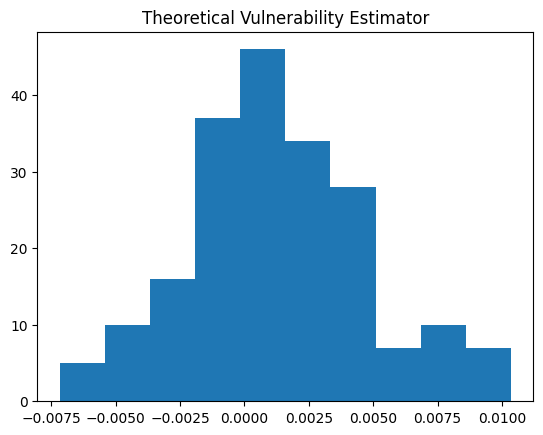

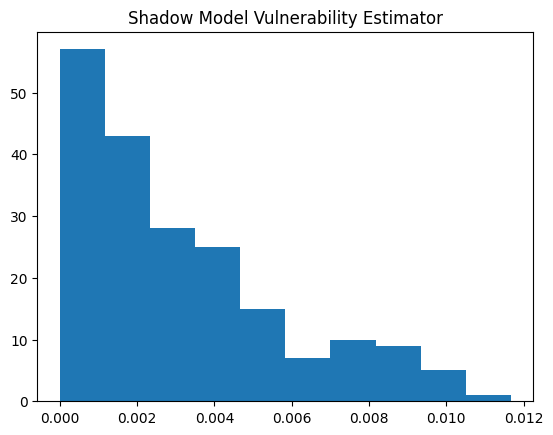

Zero One Loss Estimator Overall


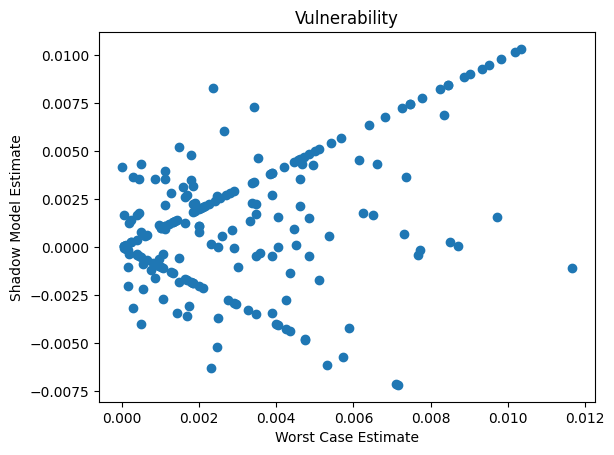

[[1.         0.39535561]
 [0.39535561 1.        ]]
Empirical Estimates
                     Average       Std
race                                  
Amer-Indian-Eskimo -0.006376  0.049096
Asian-Pac-Islander  0.005716  0.028068
Black               0.001080  0.015765
Other               0.002308  0.054815
White               0.001190  0.004250
Theoretical Estimates
                     Average       Std
race                                  
Amer-Indian-Eskimo  0.020105  0.015892
Asian-Pac-Islander  0.019638  0.013950
Black               0.006858  0.005346
Other               0.019621  0.014796
White               0.003401  0.002808


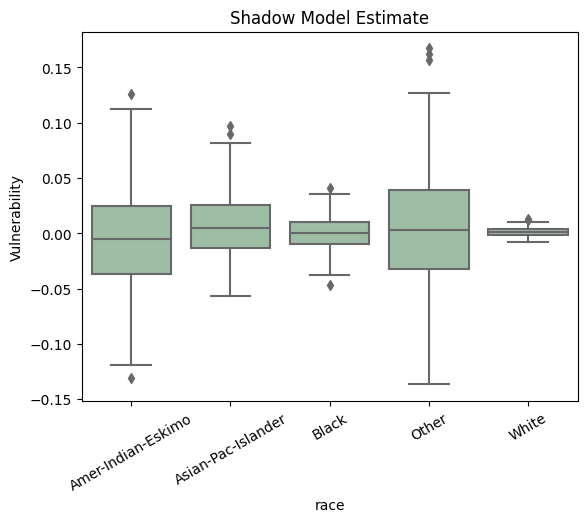

       F Value  Num DF  Den DF    Pr > F
race  2.940451     4.0   796.0  0.019808
[('Amer-Indian-Eskimo', 'Asian-Pac-Islander', -2.938 , 0.0037, 0.0369, False)
 ('Amer-Indian-Eskimo', 'Black', -2.0907, 0.0378, 0.0946, False)
 ('Amer-Indian-Eskimo', 'Other', -1.6189, 0.107 , 0.1784, False)
 ('Amer-Indian-Eskimo', 'White', -2.1694, 0.0312, 0.0946, False)
 ('Asian-Pac-Islander', 'Black',  1.9929, 0.0476, 0.0953, False)
 ('Asian-Pac-Islander', 'Other',  0.761 , 0.4475, 0.6393, False)
 ('Asian-Pac-Islander', 'White',  2.2313, 0.0268, 0.0946, False)
 ('Black', 'Other', -0.3084, 0.7581, 0.8618, False)
 ('Black', 'White', -0.0889, 0.9293, 0.9293, False)
 ('Other', 'White',  0.2855, 0.7756, 0.8618, False)]


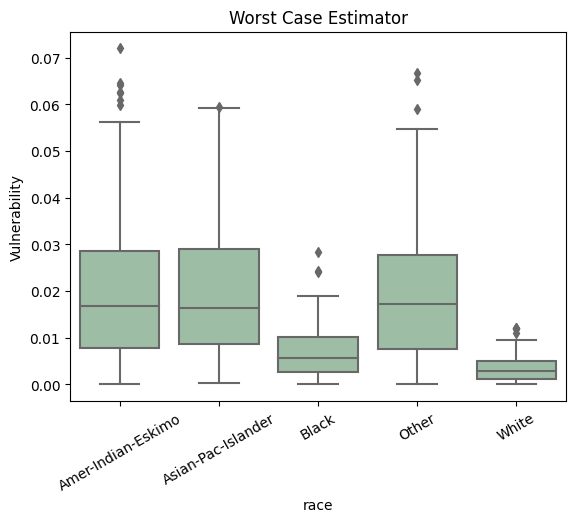

        F Value  Num DF  Den DF        Pr > F
race  95.028448     4.0   796.0  4.337837e-66
[('Amer-Indian-Eskimo', 'Asian-Pac-Islander',  3.10000e-01, 0.7569, 0.841 , False)
 ('Amer-Indian-Eskimo', 'Black',  1.12160e+01, 0.    , 0.    ,  True)
 ('Amer-Indian-Eskimo', 'Other',  3.19100e-01, 0.75  , 0.841 , False)
 ('Amer-Indian-Eskimo', 'White',  1.48282e+01, 0.    , 0.    ,  True)
 ('Asian-Pac-Islander', 'Black',  1.23858e+01, 0.    , 0.    ,  True)
 ('Asian-Pac-Islander', 'Other',  1.20000e-02, 0.9904, 0.9904, False)
 ('Asian-Pac-Islander', 'White',  1.60310e+01, 0.    , 0.    ,  True)
 ('Black', 'Other', -1.15795e+01, 0.    , 0.    ,  True)
 ('Black', 'White',  8.55030e+00, 0.    , 0.    ,  True)
 ('Other', 'White',  1.54849e+01, 0.    , 0.    ,  True)]


In [ ]:
out = run_privacy_experiments(num_sims = 200 ,
                             group_aware = False ,
                            zero_one_output = True,
                            model_obj = LogisticRegression ,
                            sklearn_model =  True )

Neural Network Victim - With Zero One Loss Release Mechansim

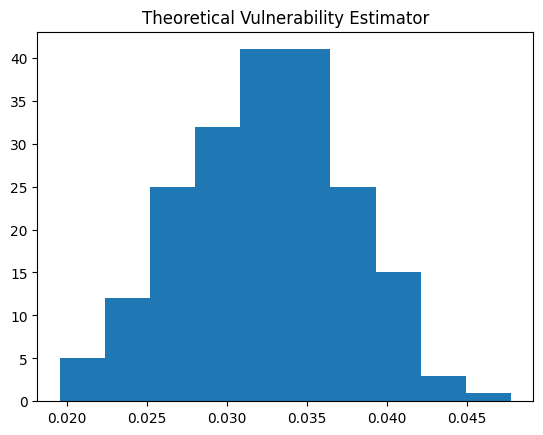

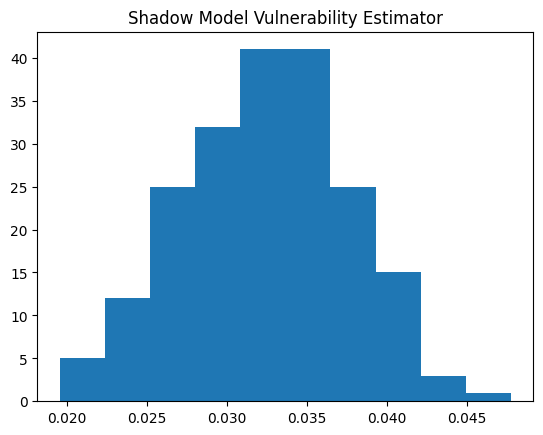

Zero One Loss Estimator Overall


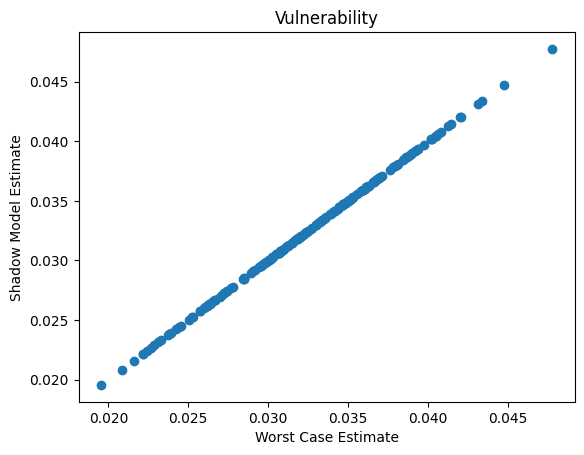

[[1. 1.]
 [1. 1.]]
Empirical Estimates
                     Average       Std
race                                  
Amer-Indian-Eskimo  0.050187  0.051180
Asian-Pac-Islander  0.129424  0.028729
Black               0.037488  0.016631
Other               0.068540  0.056124
White               0.027885  0.005071
Theoretical Estimates
                     Average       Std
race                                  
Amer-Indian-Eskimo  0.048373  0.025376
Asian-Pac-Islander  0.129149  0.021639
Black               0.037259  0.010645
Other               0.064511  0.022407
White               0.027959  0.005079


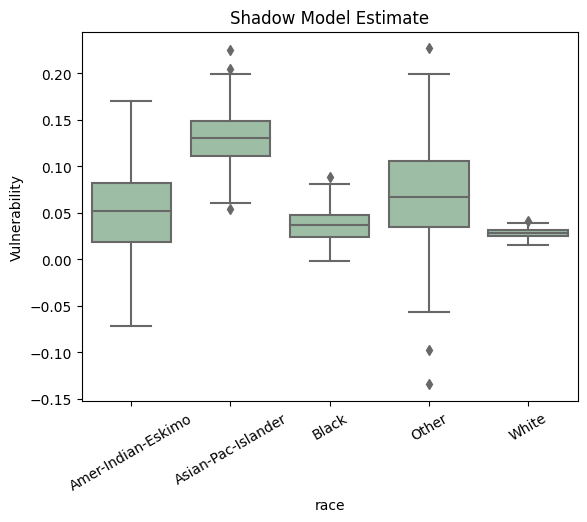

         F Value  Num DF  Den DF         Pr > F
race  234.553506     4.0   796.0  5.440307e-133
[('Amer-Indian-Eskimo', 'Asian-Pac-Islander', -18.4981, 0.    , 0.    ,  True)
 ('Amer-Indian-Eskimo', 'Black',   3.4963, 0.0006, 0.0006,  True)
 ('Amer-Indian-Eskimo', 'Other',  -3.352 , 0.001 , 0.001 ,  True)
 ('Amer-Indian-Eskimo', 'White',   6.148 , 0.    , 0.    ,  True)
 ('Asian-Pac-Islander', 'Black',  40.6659, 0.    , 0.    ,  True)
 ('Asian-Pac-Islander', 'Other',  13.5096, 0.    , 0.    ,  True)
 ('Asian-Pac-Islander', 'White',  51.7445, 0.    , 0.    ,  True)
 ('Black', 'Other',  -7.5032, 0.    , 0.    ,  True)
 ('Black', 'White',   8.1134, 0.    , 0.    ,  True)
 ('Other', 'White',  10.2026, 0.    , 0.    ,  True)]


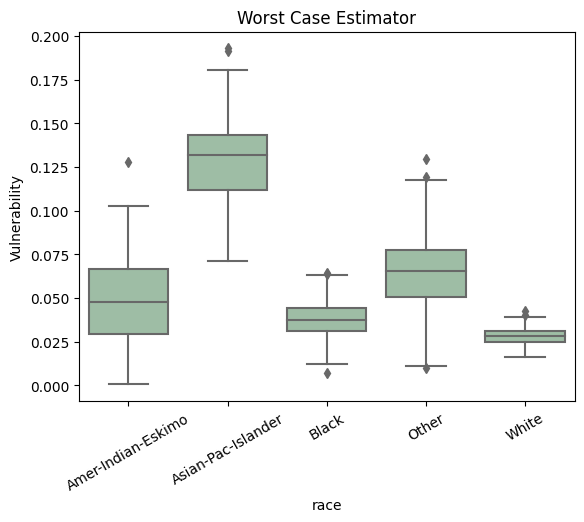

         F Value  Num DF  Den DF         Pr > F
race  1038.44667     4.0   796.0  4.395618e-314
[('Amer-Indian-Eskimo', 'Asian-Pac-Islander', -35.6164, 0., 0.,  True)
 ('Amer-Indian-Eskimo', 'Black',   6.3181, 0., 0.,  True)
 ('Amer-Indian-Eskimo', 'Other',  -6.9026, 0., 0.,  True)
 ('Amer-Indian-Eskimo', 'White',  11.4298, 0., 0.,  True)
 ('Asian-Pac-Islander', 'Black',  59.617 , 0., 0.,  True)
 ('Asian-Pac-Islander', 'Other',  31.6987, 0., 0.,  True)
 ('Asian-Pac-Islander', 'White',  69.5634, 0., 0.,  True)
 ('Black', 'Other', -16.6295, 0., 0.,  True)
 ('Black', 'White',  13.1303, 0., 0.,  True)
 ('Other', 'White',  23.4786, 0., 0.,  True)]


In [ ]:
out = run_privacy_experiments(num_sims = 200,
                             group_aware = False ,
                            zero_one_output = True,
                            model_obj = nn_victim ,
                            sklearn_model =  False)